In [1]:
# general imports usually needed
import numpy as np
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd

In [2]:
# libraries more specific to this lecture notebook
import os.path
import sys
sys.path.append('../../src')
from ml_python_class.config import DATA_DIR

from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# notebook wide settings to make plots more readable and visually better to understand
np.set_printoptions(suppress=True)

#%matplotlib widget
#%matplotlib inline

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', titlesize=18)
plt.rc('legend', fontsize=14)
plt.rcParams['figure.figsize'] = (12.0, 8.0) # default figure size if not specified in plot
plt.style.use('seaborn-darkgrid')


# 5. (Chapter 5) Support Vector Machines

A support vector machine (SVM) is a very powerful and versatile machine learning model,
capable of performing linear or nonlinear classification, regression, and even
outlier detection.  It is still one of the most popular ML models, and is a goto
technique for many researchers and in many areas, though now a-days it is not usually
considered to be the most likely to give the very best achievable performance on many
different kinds of problems.

SVM are particularly well suited for classification problems.  They perform best for small
or medium sized datasets.  Again now a-days we might be more likely to apply a deep
learning method if we have truly large data, and SVM can have some performance issues
which can limit its use for truly large datasets.

## 5.1 Linear SVM Classification

To understand how an SVM classifier works, lets fist look at the simple idea of linear separability,
and **large margin classification**.

Not all classification data is *separatable*.  If it is, we might be able to separate it with a more complex 
nonlinear function, like a polynomial, but we might not be able to use a simple line (or plane or
hyperplane in 3 or more dimensions) to separate the data.  When we can use a line or plane
to separate two classes in a dataset, the data is **linearly separable**.  Usually data is
not so simply classified, and when it is linearly separable, usually we can easily make classification
decisions about the data.

For example, taking the figure 5-1 from our textbook, if we only look at the Versicolor and
Setosa classes from the iris dataset data we have seen before, these classes 
are linearly separable using only 2 features like petal length and petal width.

However, when data is linearly separable, there will exist an (infinite) number of possible lines
we could choose to separate the two classes.  Two such successful linear separations
are shown in figure 5-1 (the red and purple solid lines).

So in a way that is similiar to our question about the best fit of a line to a data that motivated
the creation of the concept of a cost function, we can ask what is the best line or linear
boundary that we can choose to separate  classes like in this figure?  This leads to the
concept of the **largest margin**.  Informally, as shown on the left of figure 5-1, the
largest margin can be defined as the linear separation that produces the largest margin between
classes.  We can formalize this concept, though we do not do that here, and end up with a 
function that can be optimized to determine which linear separation results in the widest possible
margin for data that is linearly separable.

Like the cost function(s) we have looked at before, the widest margin determination is sensitive
to scaling issues, and you will get different results for different scalings of the features
you are separating.  For best results, features should be scaled to have close to the same
ranges, and if this is not done it can lead to poor performance for SVM models.

### 5.1.1 Soft Margin Classification

Most of the time for real data it will be impossible to linearly separate the data, and thus there
is no possible linear separation and no possible separation margin that can be given for the
dataset.

If we require that all instance be off of the margin, this is known as **hard margin classification**.
But when the data is not linearly separable, no such hard margin exists.  But we can loosen
the constraints to extend the concept by using **soft margin classification**.

Basically for an SVM classifier, you can tune a hyperparamter, known simply as `C`, that 
will loosen the constraints for a hard margin, and allow some or more points to be in or on the
wrong side of the margin.  Smaller `C` values lead to wider margines by allowing more violations of the
margin, and larger `C` make the algorithm try to keep more hard margin restrictions (at the cost of
smaller or no possible margin).  If your SVM model is overfitting, you can regularize it by
reducing C, leading to softer margins which will tend to be better at generalizing performance to
unseen data.

As usual, the scikit-learn linear SVM model fits within the framework we have seen before, and is an
transformer / estimator object.  It takes the mentioned `C` parameter, as well as other types of
regularization.

The object that performs linear SVM in scikit-learn is called `LinearSVC` for linear support
vector classifier.  We will later show that you can use SVM for regression as well, but
SVM are particularly suited to classification.  Also another different from the logistic regression,
because of the margin(s) that SVM determines for the classification, there is not the same idea
of a probability estimate for predictions.  Each item that we ask for a prediciton will be on one
side or the other of the determined linear boundary.

As an example from our textbook, we can train a linear SVM classifier on the iris virginica
/ not virginica binary classification task as follows (SVM can do multiclass classification
as well, which we will see in a bit):


In [4]:
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # iris-virginica

In [5]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LinearSVC(C=1, loss="hinge"))
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LinearSVC(C=1, loss='hinge'))])

In [6]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

As a note, the `LinearSVC` object is basically scikit-learns `SVC` (support vector classifier)
object using a "linear" kernel.  We will look at creating nonlinear classifiers next by specifying
nonlinear kernels, and what that means.  But we can get the equivalent model specifying
a linear kernal of an `SVC` instance like this.

Also there is no `loss` parameter for the `SVC` object, because 
loss (or regularization) will be a function of the type of kernel used.

In [7]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel='linear', C=100))
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=100, kernel='linear'))])

In [8]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

And finally, lets actually visualize the decision boundary.  As we have
done previously, we can use a contour plot of the prediction function
to determine where in the feature parameter space the decision changes from
1 (virginica) to 0 (not virginica)

In [9]:
# convenience function we can reuse to show decision boundaries of fitted
# models using a controur plot
def plot_svm_decision_boundary(model, X, y, 
                           class_0_label = 'Negative Class (0)', class_1_label = 'Positive Class (1)',
                           feature_1_label = r'$x_1$', feature_2_label = r'$x_2$',
                           remove_bias=False):
    '''Plot the decision boundary for a trained binary classifier.
    This method uses a contour plot and predictions from the input model
    to determine locations on a grid of points where predictions are 0 vs. 1.
    So this expectes a model that is trained on 2 features, and that is a
    binary classifier.
    
    This function is inspired/stolen from scikit-learn plot svm kernels example: 
    https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html
    
    Parameters
    ----------
    model - A scikit-learn trained classifier, when we call predict(X) on 
       the X features given as input, we expect binary predictions to be returned.
       NOTE: this funciton expects that the given trained model is actually a
       Pipeline.  It expects that the Pipeline has a 'scaler' step that is
       a standard scaler.  It expects that the Pipeline has a 'clf' step as the
       final step that is a support vector machine classifier.  This final
       `clf` should have a parameter indicating the support vectors that were
       fitt by the model.
    X     - The training data used to fit the model.  We expect X to contain 2
       features, so it should be an (m, 2) shaped array.
    y     - The true labels used to fit the model with.  Should be a vector of shape
        (m,) with the same number of lables as samples in the X training data
    remove_bias - For most models, there are only 2 features at indexes 0 and 1
        so the location of support vectors come from indexes (0, 1).  But when we
        perform a polynomial transformation by hand, we end up with a bias parameter/term
        at index 0, so need to use indexes 1 and 2 in that case from the support vectors
        reported.
        
    Returns
    -------
    No explicit result is returned.  But a matplotlib figure is created and a
    contour plot is drawn on this figure.
    '''
    # pick contrasting colors from Paired colormap for class 0 and class 1
    colors = plt.cm.Paired.colors
    c0, c1 = colors[0], colors[11]

    # plot the raw data using colors and markers for the two classes
    plt.plot(X[y==0, 0], X[y==0, 1], 
             "o", color=c0, label=class_0_label, zorder=10, markeredgecolor='k'
    )
    plt.plot(X[y==1, 0], X[y==1, 1], 
             "s", color=c1, label=class_1_label, zorder=10, markeredgecolor='k'
    )
    
    # indicate the support vectors used in the model classifier, we put a bigger 
    # circle around these to indcate the one used by svm classifier
    support_vectors = model['clf'].support_vectors_
    support_vectors_rescaled = model['scaler'].inverse_transform(support_vectors)
    x1_index, x2_index = 0,1
    if remove_bias:
        x1_index, x2_index = 1,2
    plt.scatter(support_vectors_rescaled[:, x1_index], support_vectors_rescaled[:, x2_index],
        s=150,
        facecolors="none",
        zorder=10,
        edgecolors="k",
    )

    # use determined figure axis limits to determine ranges for grid coverage
    plt.axis('tight')
    axes = plt.gca()
    x1_min, x1_max = axes.get_xlim()
    x2_min, x2_max = axes.get_ylim()

    # create grid of points over the plot to use contour plot to visualize decision boundary
    X1, X2 = np.mgrid[x1_min:x1_max:200j, x2_min:x2_max:200j]
    
    # use decision funciton of trained classifier to determine decisions over the grid
    Z = model.decision_function(np.c_[X1.ravel(), X2.ravel()])
    Z = Z.reshape(X1.shape)
    
    # visualize decision boundary, pcolormesh plots colors (c0, c1) on the mesh of points
    # where the decision was 0/1 respectively
    plt.pcolormesh(X1, X2, Z > 0, cmap=plt.cm.Paired)
    
    # visualize decision boundary and margins.  The decision function is before the sigmoid is done, thus where the level is 0
    # will be where the decision is 0.5, or in otherwords the decision boundary.
    # Levels of -1.0 and 1.0 correspond (roughly?) to the SVM RELU margin.  I.e. I believe this is roughly where the default
    # RELU transitions from horizontal to linear function
    CS = plt.contour(X1, X2, Z,
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
            levels=[-1.0, 0, 1.0],
         )

    # add labels and plot information
    plt.xlabel(feature_1_label, fontsize=14)
    plt.ylabel(feature_2_label, fontsize=14)
    
    # add legend, by hand get the contour line handles and add to handles and labels before we
    # display the legend
    h1, _ = CS.legend_elements()
    handles, labels = axes.get_legend_handles_labels()
    contour_labels = ['support margin', 'decision boundary', 'support margin']
    for h,l in zip(h1[1:], contour_labels[1:]):
        handles.append(h)
        labels.append(l)
    plt.legend(handles, labels, fontsize=14)


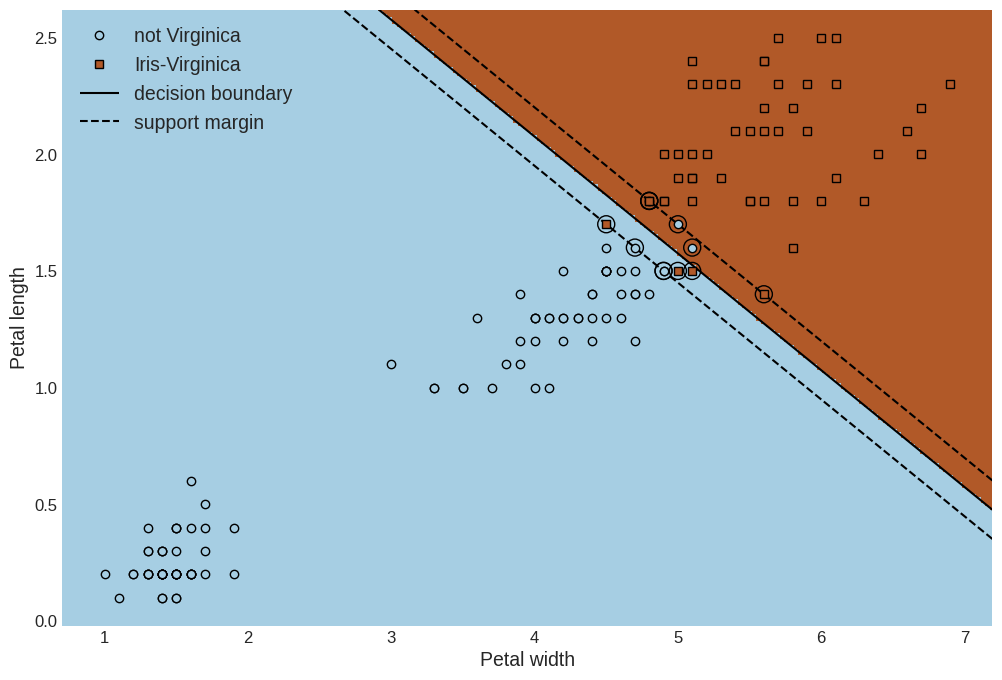

In [10]:
plot_svm_decision_boundary(svm_clf, X, y, 
                           class_0_label='not Virginica', class_1_label='Iris-Virginica',
                           feature_1_label='Petal width', feature_2_label='Petal length')

## 5.2 Nonlinear SVM Classification

Although linear SVM classifiers are efficient and work surprisingly well in many cases,
many datasets are not even close to being linearly separable. One approach to handling
nonlinear datasets is to add more features, such as polynomial feature, as we did in a
previous assignment (this works in general for many other methods that create linear
decision boundaries or linear fits of the data).

To implement this idea using Scikit-Learn, create a Pipeline containing a
PolynomialFeatures transformer (discussed in “Polynomial Regression”), followed by a
StandardScaler and a LinearSVC. Let’s test this on the moons dataset: this is a toy dataset
for binary classification in which the data points are shaped as two interleaving half circles.

In [11]:
X, y = make_moons(n_samples=100, noise=0.15)

polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel='linear', C=10, max_iter=10000))
])

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('clf', SVC(C=10, kernel='linear', max_iter=10000))])

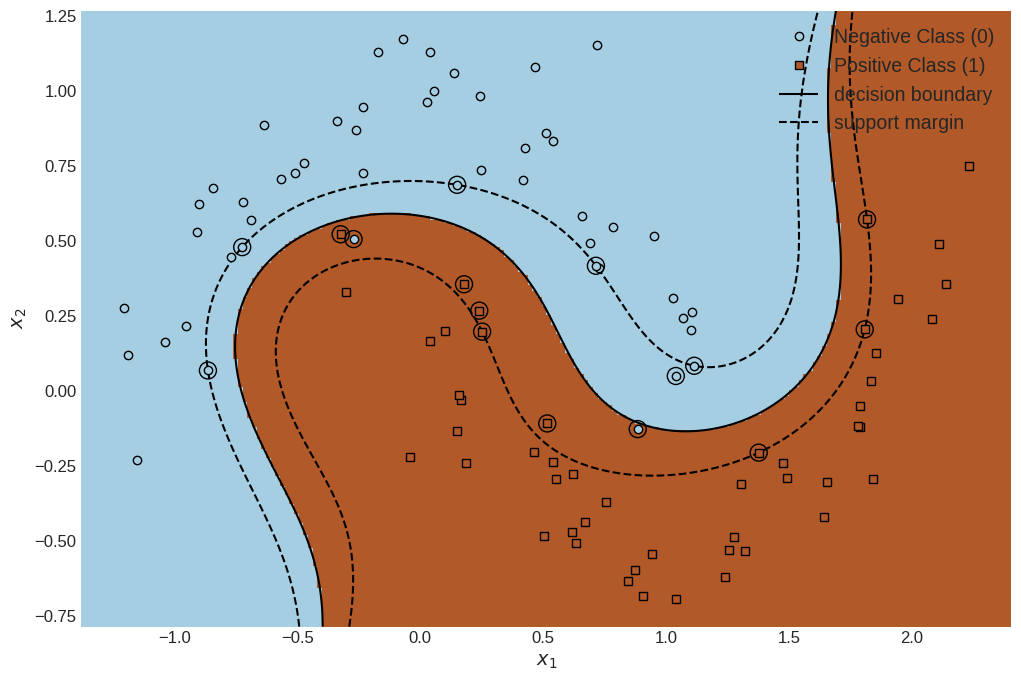

In [12]:
plot_svm_decision_boundary(polynomial_svm_clf, X, y, remove_bias=True) 

### 5.2.1 Polynomial Kernel

Adding polynomial features is simple to implement and can work great with all sorts of
Machine Learning algorithms (not just SVMs). That said, at a low polynomial degree, this
method cannot deal with very complex datasets, and with a high polynomial degree it
creates a huge number of features, making the model too slow.

Fortunately, when using SVMs you can apply an almost miraculous mathematical
technique called the kernel trick (explained in a moment). The kernel trick makes it
possible to get the same result as if you had added many polynomial features, even with
very high-degree polynomials, without actually having to add them. So there is no
combinatorial explosion of the number of features because you don’t actually add any
features. This trick is implemented by the SVC class. Let’s test it on the moons dataset:

In [13]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=5, coef0=1, kernel='poly'))])

This code used a 3rd degree polynomial kernel.  

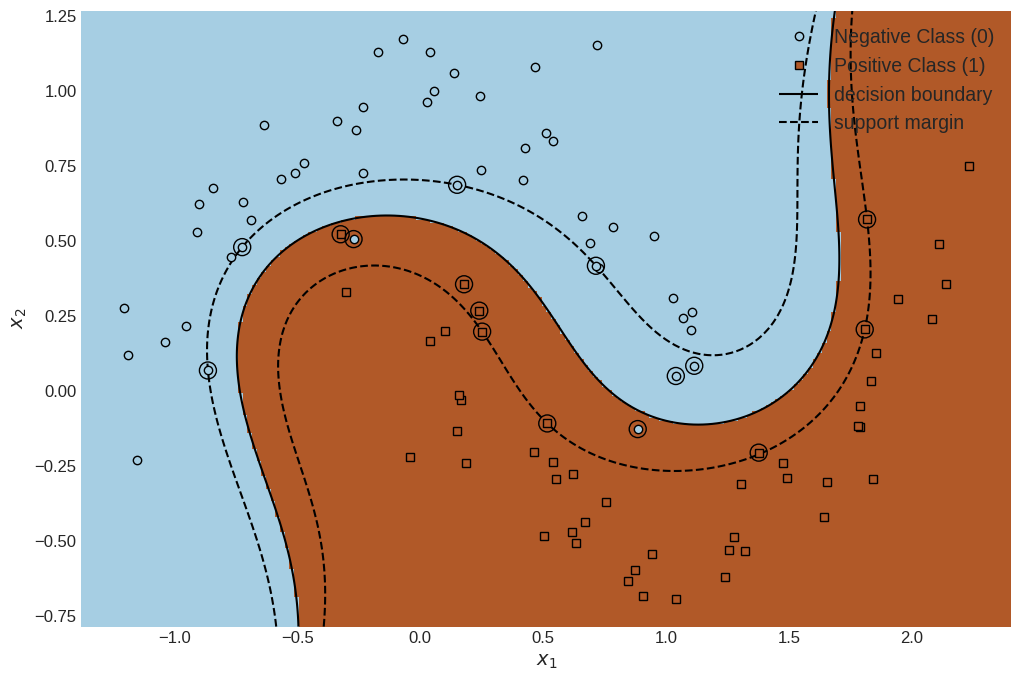

In [14]:
plot_svm_decision_boundary(poly_kernel_svm_clf, X, y) 

The term `C` for support vector machines controls the amount of regularization.
The `coef0` (which was labeled `r` in our textbook for some reason), controls how much the mode is influenced
by high-degree polynomials vs. low-degree ones (this coef0 is only valid for `polynomial` SVC kernels).
So both of these meta-parameters canhave effects on regularization, and can thus be used to fight overfitting or
loosen up if underfitting.

It is worthwhile seeing the effects of modifying these parameters on the performance of the model with a
`polynomial` kernel.  C is similar to $\alpha$ that we saw before to control regularization, but it
has an inverse effect.  So for Lasso and Ridge regression, if we wanted to give more weight to the
regularization penality we used a high value of $\alpha$.

But `C` is reversed here.  So if I want to fight overfitting we need a small value of `C`.  For example, we expect the
`polynomial` kerenel to go back to being a linear model if we use small `C` for an SVC.

In [15]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="poly", degree=3, coef0=1, C=0.0001))
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=0.0001, coef0=1, kernel='poly'))])

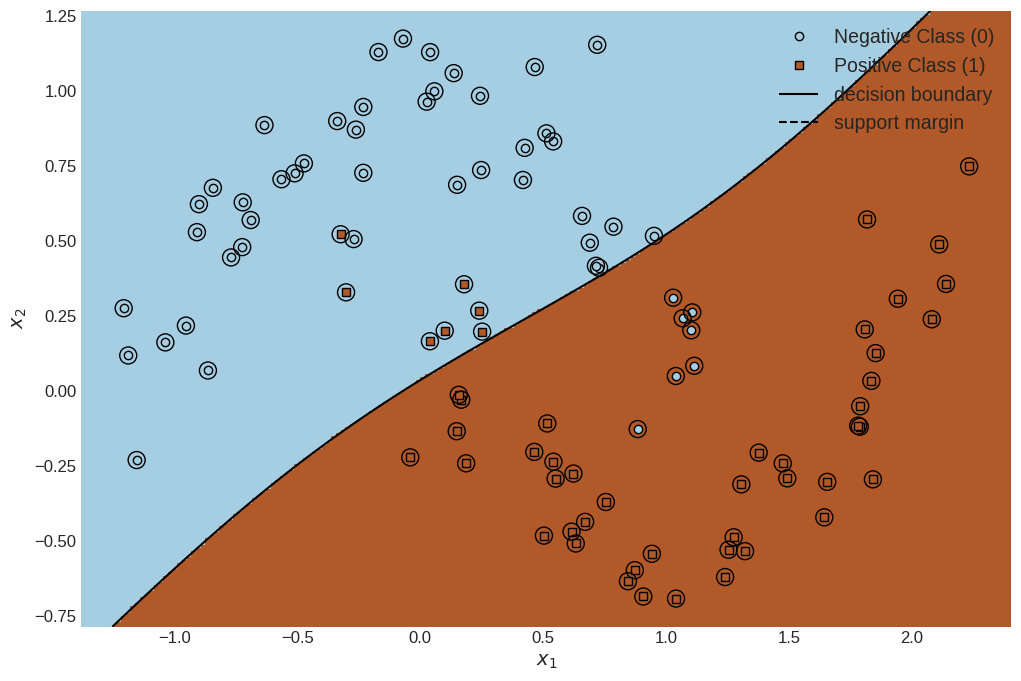

In [16]:
plot_svm_decision_boundary(poly_kernel_svm_clf, X, y) 

Conversely, you can overfit pretty easily but increasing the `degree` of the polynomial kernel,
and making `C` large.

In [17]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="poly", degree=20, coef0=1, C=100))
])

poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=100, coef0=1, degree=20, kernel='poly'))])

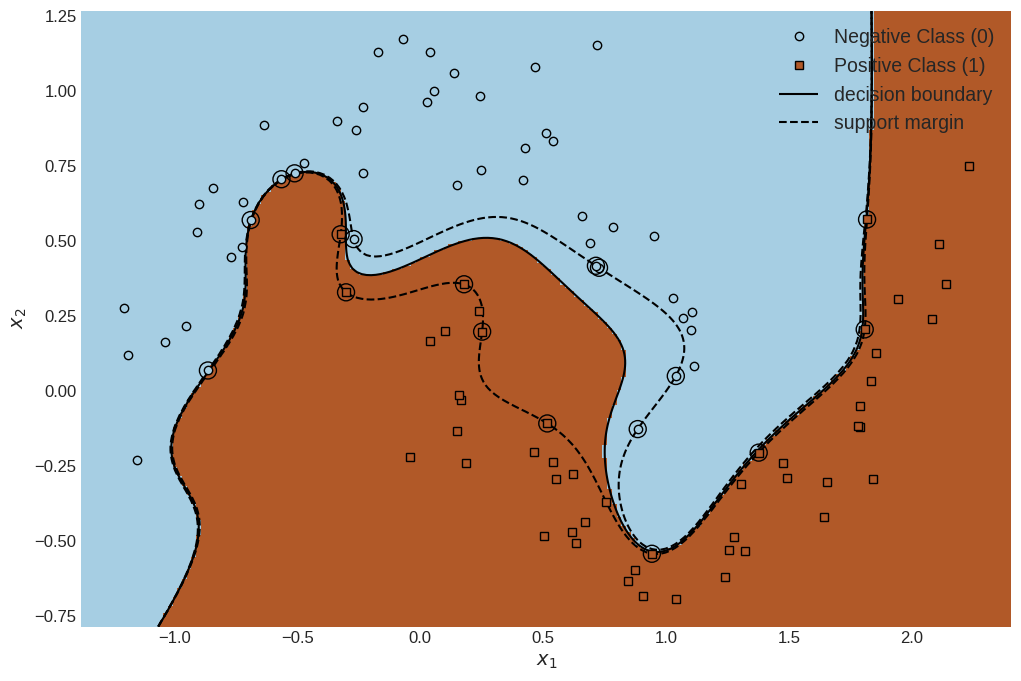

In [18]:
plot_svm_decision_boundary(poly_kernel_svm_clf, X, y) 

This model is probably very overfit to this training data.  For example, there is no margin and it decision boundry
goes very close to the negative class in spots.  It will perfectly classify this data it was trained with, but may
not do well on unseen data here.

The `coef0` is discussed a bit in the book as well.  You can tune overfitting by using high `coef0` for a polynomial kernel, as it will
lessen the importance of the higher degree polynomials.

### 5.2.2 Similarity Features

Another technique to tackle nonlinear problems is to add features computed using a
**similarity function**, which measures how much each instance resembles a particular
**landmark**.


Out texbook gives the following expression for the **Gaussian Radial Basis Function** (RBF):

\begin{equation}
\newcommand\norm[1]{\lVert#1\rVert}
\phi_\gamma(\textbf{x}, \ell) = \exp( \; -\gamma \; \norm{\textbf{x} - \ell}^2 )
\end{equation}



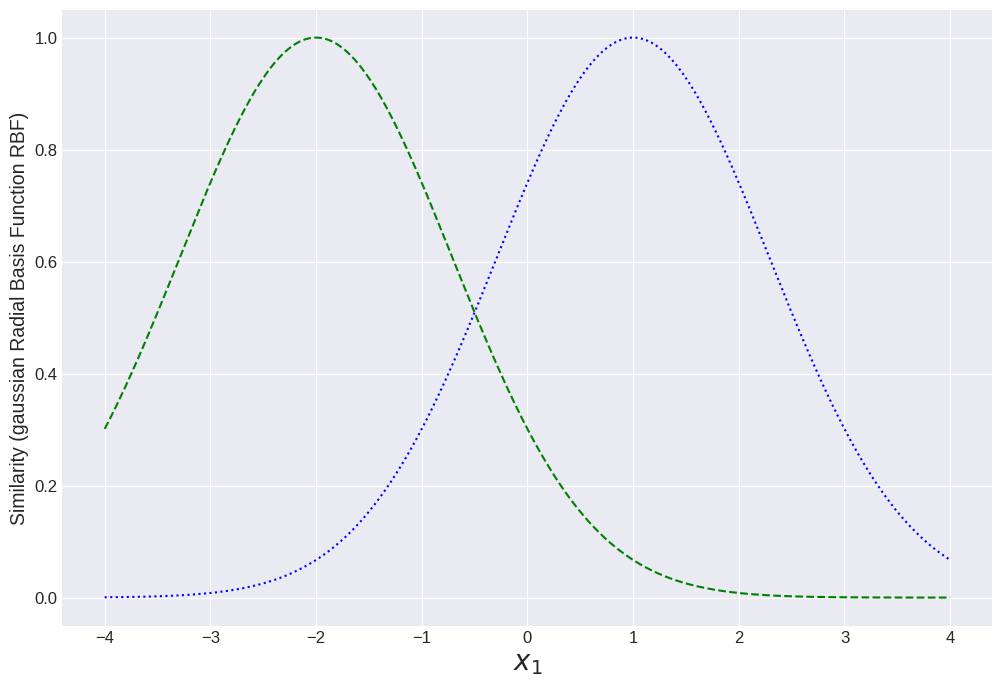

In [19]:
def gaussian_rbf(x, ell, gamma):
    '''Compute Gaussian RBF function for a vector x.
    
    Parameters
    ----------
    ell - controls the center or mean of the RBF, we called this \mu or mean in Dr. Ngs videos. 
    gamma - controls the spread or standard deviation of the function.  The inverse of this corresponds
       to \sigma from Dr. Ngs videos, e.g. 1 / gamma
       
    Returns
    -------
    similarity - Returns calculated RBF Similarity for all points in the given vector x.  So the returned
       similiarity should be a vector of the same size and shape as input x
    '''
    return np.exp( -gamma * (x - ell)**2.0 )
    
x = np.linspace(-4.0, 4.0, 1000)
plt.figure()

# feature x_2 centered at x_1 = -2 with a gamma = 0.3
ell = -2.0
gamma = 0.3
plt.plot(x, gaussian_rbf(x, ell, gamma), 'g--')

# feature x_3 centered at x_1 = 1 with a gamma = 0.3
ell = 1.0
plt.plot(x, gaussian_rbf(x, ell, gamma), 'b:')

plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('Similarity (gaussian Radial Basis Function RBF)');

**NOTE**:  Our book uses the above notation.  Here $\ell$ or `ell` is the location of the center point (the mean
or $\mu$) of the similarity function.  Likewise $\gamma$ or `gamma` controls the spread of the similarity, how
fast similarity goes from 1 to 0 (the standard deviation or $\sigma$).

If you watch Dr. Ng's videos, you will see the Gaussian RBF discussed using this form:

$$
f_1 = \mathrm{exp} \Big(- \frac{ \|x - \ell\|^2 }{2 \sigma^2} \Big)
$$


Here $\ell$ is the same, it is where the similarity function is centered.  But the spread is parameterized differently.

Scikit-learn uses the $\gamma$ `gamma` as the parameter, as shown above.  You can convert between them because 

\begin{equation}
\begin{aligned}
\gamma &= \frac{1}{2 \sigma^2} \\
\sigma &= \sqrt{\frac{1}{2 \gamma}}
\end{aligned}
\end{equation}

So using Dr. Ng notation, we get the equivalent if we use a `sigma` 

\begin{equation}
\sigma = \sqrt{\frac{1}{2 \cdot 0.3}} \approx 1.29099
\end{equation}

So as an alternative, here is the RBF using `sigma` $\sigma$, and we demonstrate these are equivalent.

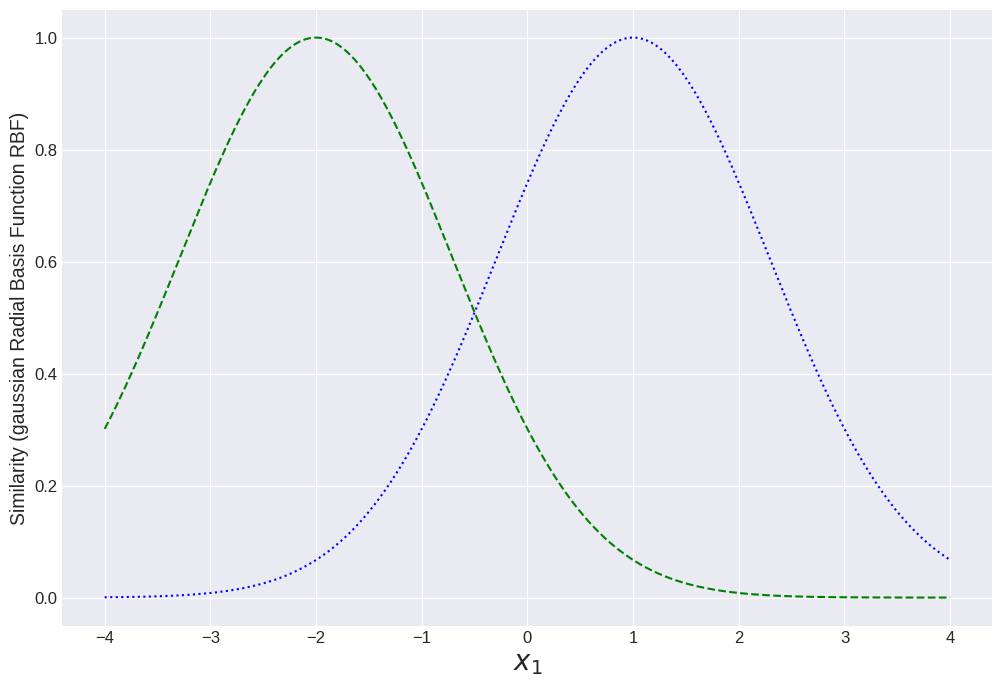

In [20]:
def gaussian_rbf_ng(x, mu, sigma):
    return np.exp(- (x - mu)**2.0 / (2 * sigma**2.0))

x = np.linspace(-4.0, 4.0, 1000)
plt.figure()

# convert from sigma to gamma
sigma = np.sqrt(1 / (2.0 * 0.3))

# feature x_2 centered at x_1 = -2 with a gamma = 0.3
ell = -2.0
plt.plot(x, gaussian_rbf_ng(x, ell, sigma), 'g--')

# feature x_3 centered at x_1 = 1 with a gamma = 0.3
ell = 1.0
plt.plot(x, gaussian_rbf_ng(x, ell, sigma), 'b:')

plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('Similarity (gaussian Radial Basis Function RBF)');

Returning back to the textbook example of Figure 5-8.  This is demonstrating how selecting landmarks and calculating 
similarity on the original input features can perform a nonlinear transformation.

In this example, we had a set of samples with a single feature $x_1$.  We define two landmarks as above, at
$x_1 = -2$ and $x_1 = 1$.  The 9 sampled points were in 2 classes, but these are not linearly separable.

In [21]:
# nonseparable dataset of a single feature x_1 with 2 classes
x1 = np.linspace(-4, 4, 9) # x_1 features
y = np.array([1, 1, 0, 0, 0, 0, 0, 1, 1]) # nonseparable class labels

print(x1)
print(y)

[-4. -3. -2. -1.  0.  1.  2.  3.  4.]
[1 1 0 0 0 0 0 1 1]


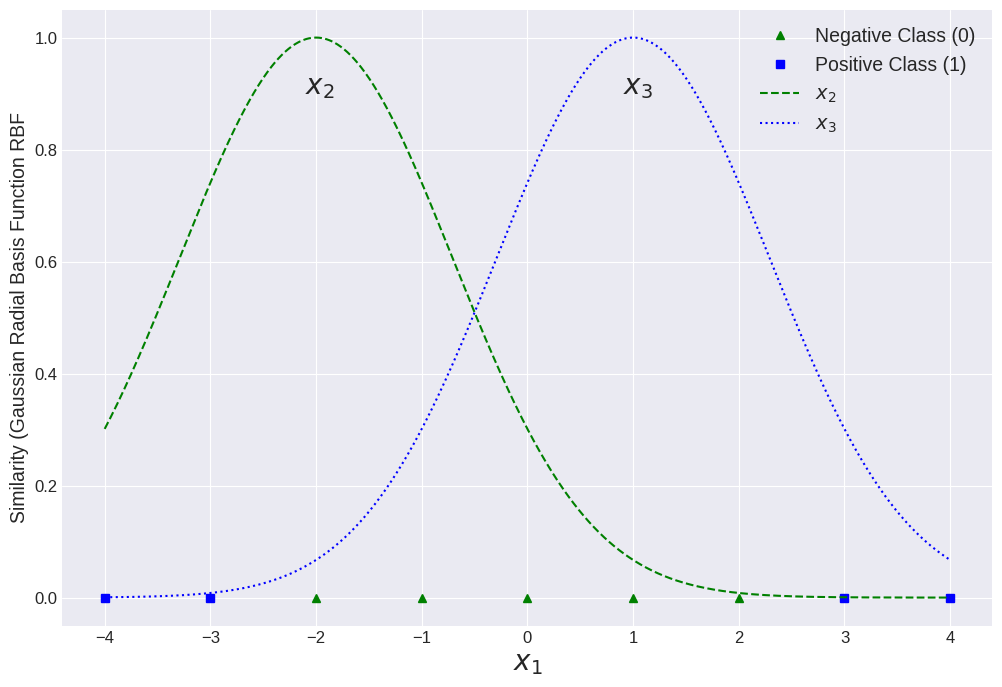

In [22]:
# recreate figure 5-8 left

# plot the input features and indicate class using shape and color
class0 = x1[y==0]
y0 = np.zeros(len(class0))
plt.plot(class0, y0, 'g^', label='Negative Class (0)')

class1 = x1[y==1]
y1 = np.zeros(len(class1))
plt.plot(class1, y1, 'bs', label='Positive Class (1)')

# show the first landmark at x_1 = -2, that we call feature x_2 in transformed space
x_grid = np.linspace(-4.0, 4.0, 1000)
plt.plot(x_grid, gaussian_rbf(x_grid, -2.0, 0.3), 'g--', label=r'$x_2$')
plt.text(-2.1, 0.9, r'$x_2$', fontsize=20)
plt.plot(x_grid, gaussian_rbf(x_grid, 1.0, 0.3), 'b:', label=r'$x_3$')
plt.text(0.9, 0.9, r'$x_3$', fontsize=20)

# add in figure labels and legend
plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel('Similarity (Gaussian Radial Basis Function RBF')
plt.legend();

In this example, the right hand Figure 5-8 is demonstrating how we use Gaussian RBF similarity to create
2 new features which are a nonlinear transformation of the original nonseparable feature.
Since we define 2 landmarks, we end up with 2 new features.  The features we now called $x_2$ and
$x_3$ are the measures of the similarity of the original feature $x_1$ to the two landmarks
we have choosen.

So to use and RBF kernel, it works pretty similar to doing a Polynomial nonlinear transformation before
passing the new set of features to a SVM classifier.  In the case of an RBF kernel, we calculate the
similarity of each of the original $x_1$ features to the two landmarks, like this:

In [23]:
x2 = gaussian_rbf(x1, -2.0, 0.3)
x3 = gaussian_rbf(x1, 1.0, 0.3)

X = np.stack([x2, x3], axis=1)
print(X.shape)

(9, 2)


After calculating similarity for our two new landmark/features $x_2$ and $x_3$, we can
recreate the figure 5-8 right plot.

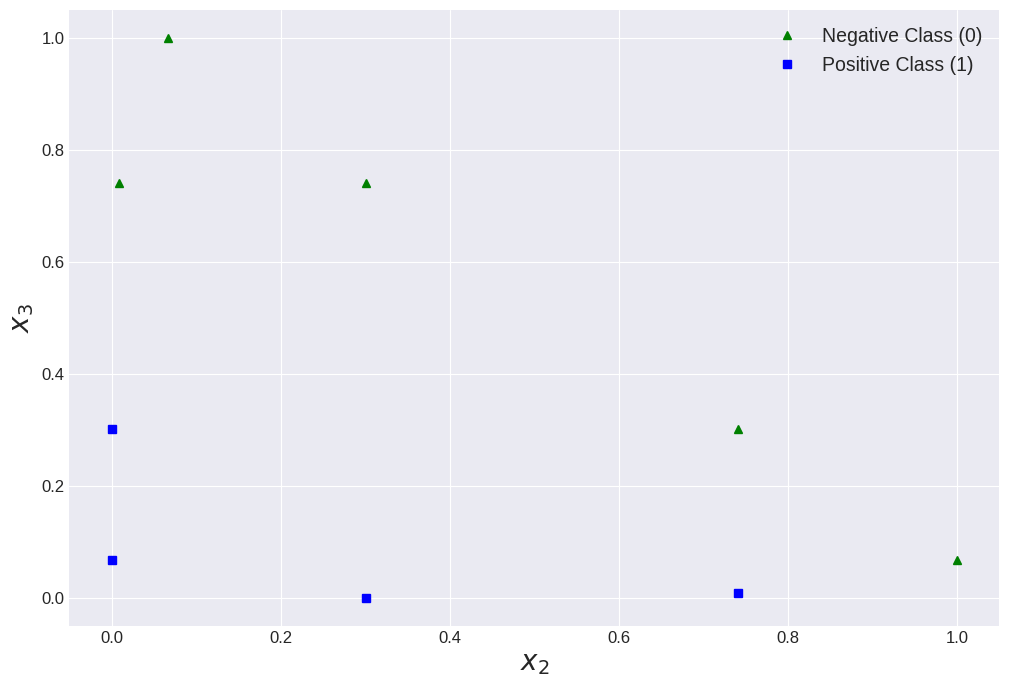

In [24]:
# recreate figure 5-8 left

# plot the input features and indicate class using shape and color
class0 = X[y==0]
plt.plot(class0[:,0], class0[:,1], 'g^', label='Negative Class (0)')

class1 = X[y==1]
plt.plot(class1[:,0], class1[:,1], 'bs', label='Positive Class (1)')

# add in figure labels and legend
plt.xlabel(r'$x_2$', fontsize=20)
plt.ylabel(r'$x_3$', fontsize=20)
plt.legend();

Then, not shown in the text, but just as we did when we created polynomial features by hand, after
generating a new set of features using RBF similarity, we can fit a linear SVC to this transformed
data.  Since the RBF similarity is a nonlinear transformation, this new space of features might be more easily 
linearly separable by a classifier.

In [25]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel='linear', C=100))
])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=100, kernel='linear'))])

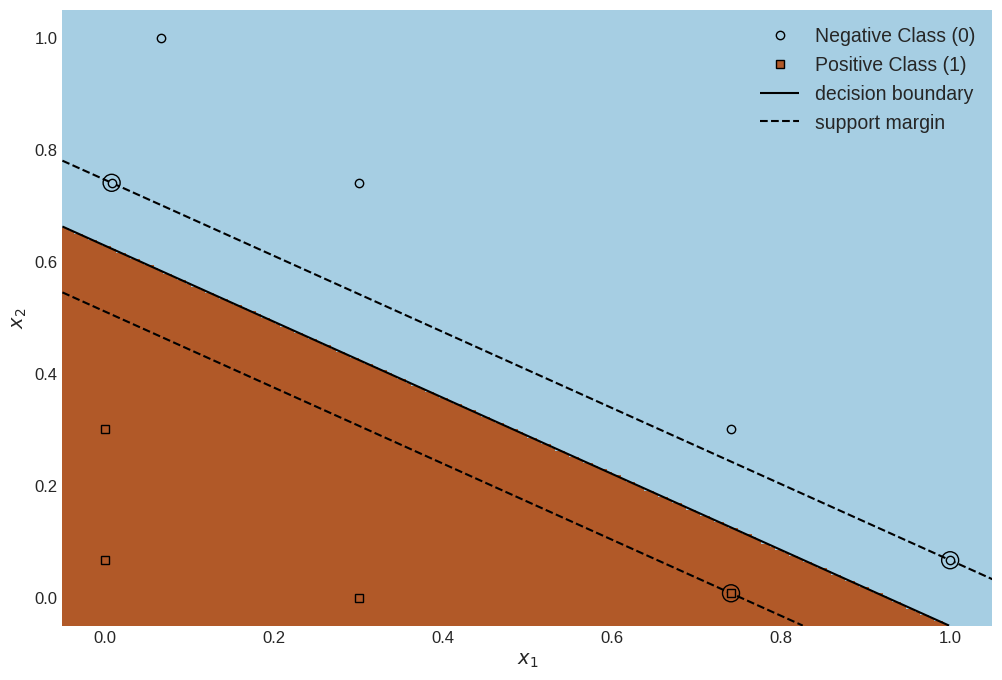

In [26]:
plot_svm_decision_boundary(svm_clf, X, y) 

### 5.2.3 Gaussian RBF Kernel

Just like the polynomial features method, the similarity features method can be useful with
any Machine Learning algorithm, but it may be computationally expensive to compute all
the additional features, especially on large training sets. Once again the kernel trick does
its SVM magic, making it possible to obtain a similar result as if you had added many
similarity features.

One note, as discussed in the textbook, the default when using an RBF kernel is just to set a landmark for
every input sample you give when fitting the model.  So for example, using the moon data again, we have 2
randomly generated features.  But we generated this data in the following cell again using 100 samples.
So the default if we ask for an RBF kernel is to end up with 100 RBF similarity features, each centered
at the original location of the training sample points.

Notice below that you can specify `C` still for the SVM classifier, and it works as before to
increase or decrease the effects of the regularization penality.  Also for an RBF kernel, you
can specify the `gamma` as another metaparameter.  This is the `gamma` $\gamma$ we used above
to determine the standard deviation or spread of the similarity function.

Increasing gamma makes the bell-shaped curve narrower. As a result, each
instance’s range of influence is smaller: the decision boundary ends up being more
irregular, wiggling around individual instances. Conversely, a small gamma value makes the
bell-shaped curve wider: instances have a larger range of influence, and the decision
boundary ends up smoother.

So `gamma` $\gamma$ acts like anothre kind of regularization hyperparameter.  If your model
is overfitting, you should reduce `gamma`.  If it is underfitting, you should increase it.
Similar to the `C` hyperparameter.

Similar to Figure 5-9 from our text, here are several examples on the moon database, again with
100 randomly generated samples with two original features.  We use an RBF kernel, and show the effect
of changing gamma.

In [27]:
# make the moon random dataset again
X, y = make_moons(n_samples=100, noise=0.15)

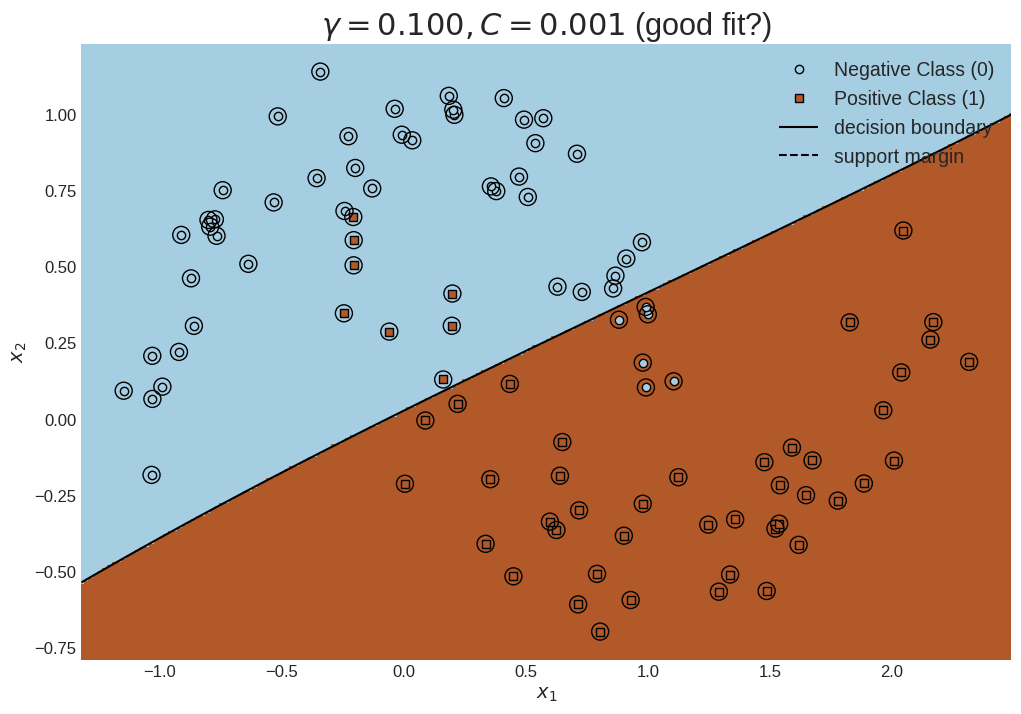

In [28]:
# small gamma and C
gamma = 0.1
C = 0.001

rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", gamma=0.1, C=0.001))
])

rbf_kernel_svm_clf.fit(X, y)

plot_svm_decision_boundary(rbf_kernel_svm_clf, X, y)
plt.title(r'$\gamma = %0.3f, C = %0.3f$ (good fit?)' % (gamma, C), fontsize=22);

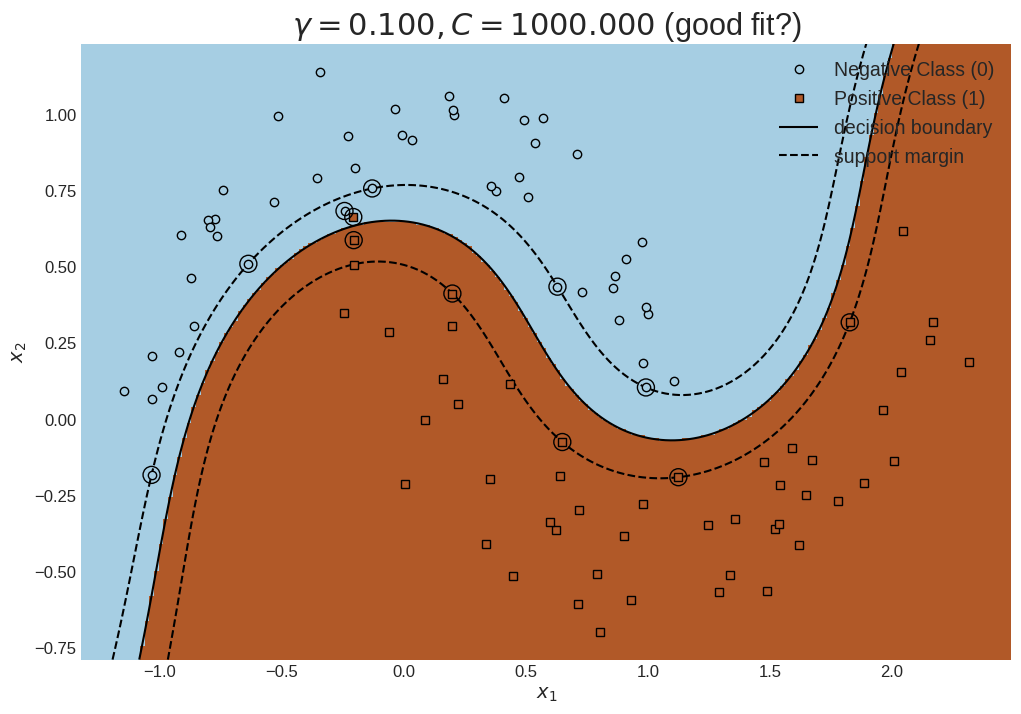

In [29]:
# small gamma large C
gamma = 0.1
C = 1000

rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", gamma=gamma, C=C))
])

rbf_kernel_svm_clf.fit(X, y)

plot_svm_decision_boundary(rbf_kernel_svm_clf, X, y)
plt.title(r'$\gamma = %0.3f, C = %0.3f$ (good fit?)' % (gamma, C), fontsize=22);

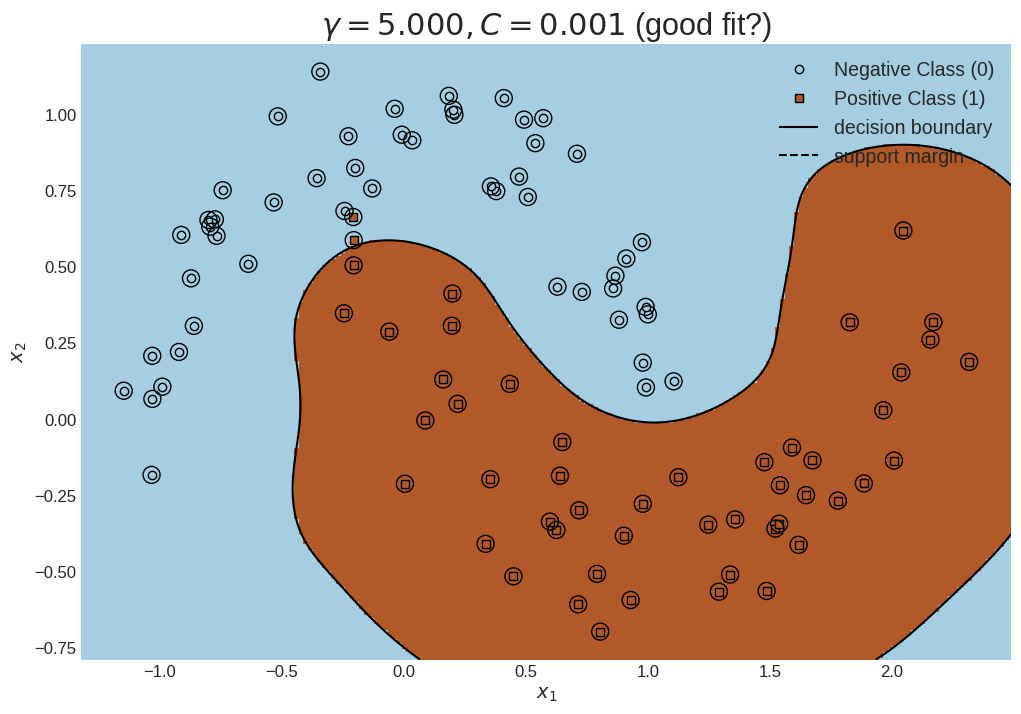

In [30]:
# large gamma but small C this time
gamma = 5
C = 0.001

rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", gamma=gamma, C=C))
])

rbf_kernel_svm_clf.fit(X, y)

plot_svm_decision_boundary(rbf_kernel_svm_clf, X, y)
plt.title(r'$\gamma = %0.3f, C = %0.3f$ (good fit?)' % (gamma, C), fontsize=22);

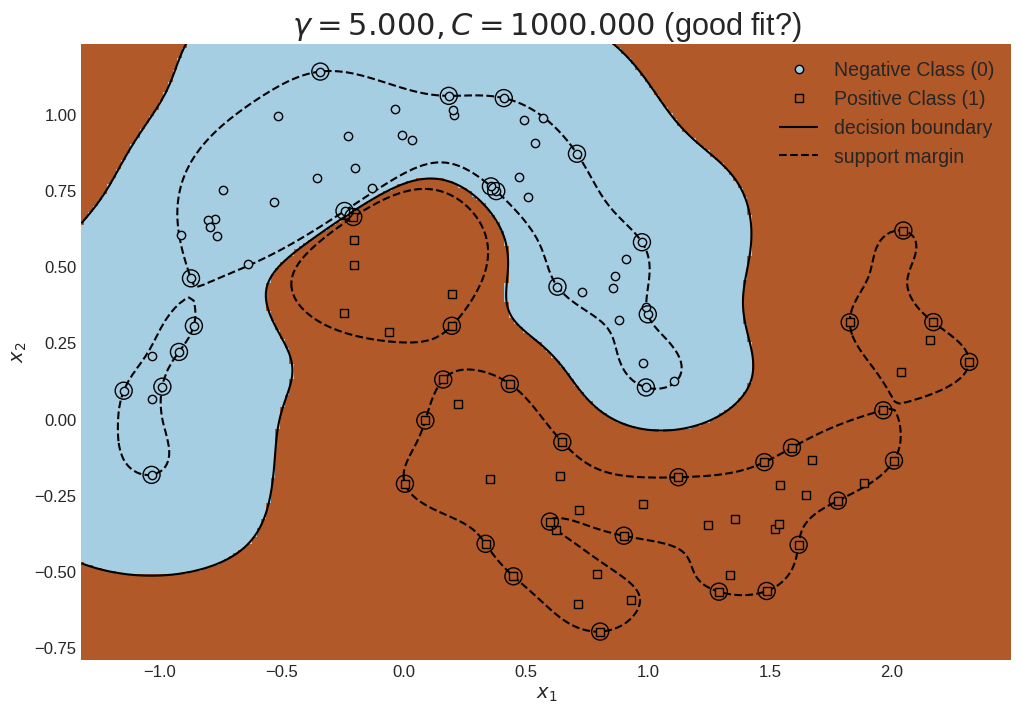

In [31]:
# large gamma and large C this time
gamma = 5
C = 1000

rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", gamma=gamma, C=C))
])

rbf_kernel_svm_clf.fit(X, y)

plot_svm_decision_boundary(rbf_kernel_svm_clf, X, y)
plt.title(r'$\gamma = %0.3f, C = %0.3f$ (good fit?)' % (gamma, C), fontsize=22);

### 5.2.3 Computational Complexity

The `LinearSVC` implements an optimized algorithm for linear SVMs.  It does not support the kernel trick, but it scales almost linearly with the number of
training instances and the number of features $\mathcal{O}(m \times n)$  In short, if you don't need a nonlinear decision boundary, the 
`LinearSVC` is available in `Scikit-Learn` to provide a highly optimized and fast version for very large datasets.

So the main difference then with the `SVC` class is that it supports kernel nonlinear transformations.  Training complexity if using a kernel is
between $\mathcal{O}(m^2 \time n)$ and $\mathcal{O}(m^3 \times n)$.  Here recall $m$ refers to the number of training samples.  So it can get slow to train
if a large number of training samples are being used (e.g. hundreds of thousands of samples).  But it scales well with the number
of features $n$.

Note mentioned, but I believe that the discussion here refers to using Gaussian RBF kernels.  These by default set a new feature/landmark for each of
the $n$ features, which is why they scale with the size of $n$.  But if you create all possible Polynomial combinations of $n$ features, the
amount of new features grows much faster.  

For example, if you go from 10 features to 100 features, that is only 10 times as many RBF features.  

But lets say we have 10 features, and we want to go up to a degree 3 polynomial.  We get the following:

In [32]:
# represent 100 randomly generated samples of 10 features
m = 100
n = 10
X = np.random.randn(m, n)
print(X.shape)

(100, 10)


In [33]:
p = PolynomialFeatures(degree=3)
X_new = p.fit_transform(X)
print(X_new.shape)

(100, 286)


But now if your number of features $n$ goes from 10 to 100, we don't have a linear increase to 2860 features:

In [34]:
# increase number of features by 10 times, 1 order of magnitude
n = 100

X = np.random.randn(m, n)
print(X.shape)

(100, 100)


In [35]:
p = PolynomialFeatures(degree=3)
X_new = p.fit_transform(X)
print(X_new.shape)

(100, 176851)


This is not a linear increase, and is much worse if you want higher degree polynomials for the feature transformations.

Usually RBF kernels work as well as polynomial feature kernels, but with much less increase in the number of needed
new features.

## 5.3 SVM Regression

The SVM algorithm is versatile: not only does it support linear and
nonlinear classification, but it also supports linear and nonlinear regression. To use SVMs
for regression instead of classification, the trick is to reverse the objective: instead of
trying to fit the largest possible street between two classes while limiting margin
violations, SVM Regression tries to fit as many instances as possible on the street while
reducing non margin violations to as few as possible.

The `LinearSVR` class performs a regression fit using the support vector algorithm.  As described this
is a Linear version of SVM, where the default parameters/assumptions is to try and maximize
the margin violations.

The hyperparameter used for SVM regression is called `epsilon` or $\epsilon$.  Large `epsilon`
values give a larger street, so are more underfit.  And smaller epsilon reduce the street, which
may lead to overfitting.

Here is a quick example reproducing the Figure 5-10 from our textbook.  We generate a set of random data
with a single feature $x_1$ and fit a linear SVR to the data.

In [36]:
# line estimated from Figure 5-10 with slope of m=3 and intercept at about y=3.5
# we add in random noise to look about what the figure is using
slope = 3
intercept = 3.5

x = np.random.uniform(0, 2, (100,))
y = intercept + slope * x
y = y + np.random.normal(0, 0.5, (100,))
x = x.reshape((100,1))

In [37]:
epsilon = 1.5
svm_reg = SVR(kernel='linear', epsilon=epsilon)
svm_reg.fit(x, y)

SVR(epsilon=1.5, kernel='linear')

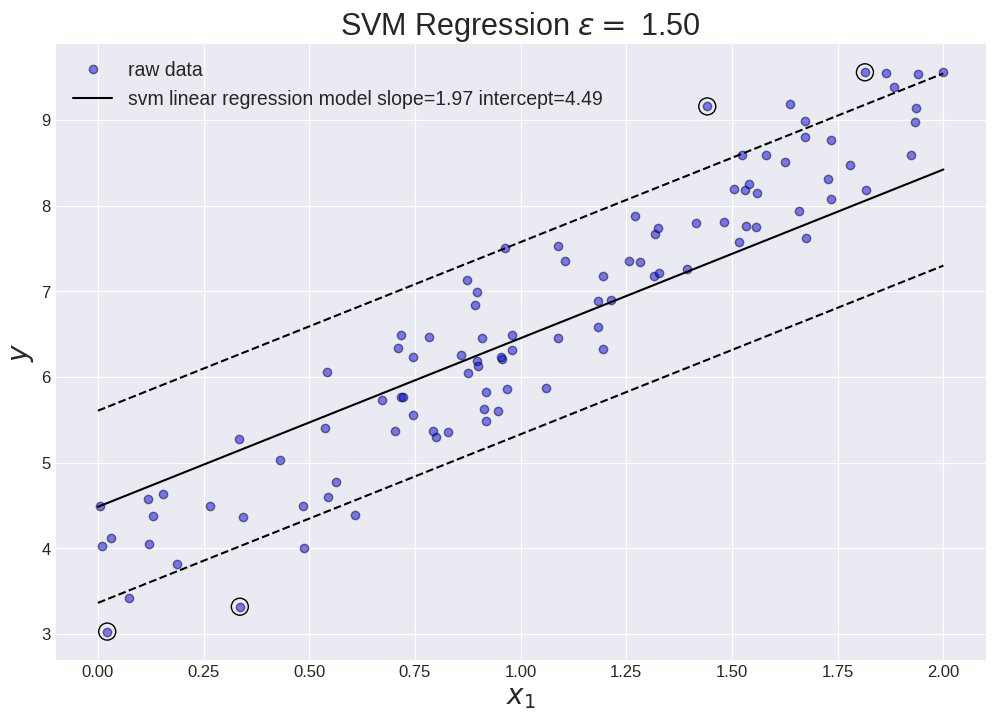

In [38]:
# visualize the linear regression fit

# first plot the raw data
plt.plot(x, y, 'bo', alpha=0.5, markeredgecolor='k', label='raw data')

# Can get model regression line using basic predict function as usual
x_grid = np.linspace(0.0, 2.0, 2).reshape(2,1)
y_hat = svm_reg.predict(x_grid)
model_slope = svm_reg.coef_[0]
model_intercept = svm_reg.intercept_
label = 'svm linear regression model slope=%0.2f intercept=%0.2f' % (model_slope, model_intercept)
plt.plot(x_grid, y_hat, 'k-', label=label)

# identify the support vectors found by this SVR
sv_x = svm_reg.support_vectors_
sv_y_idx = svm_reg.support_
plt.scatter(sv_x, y[sv_y_idx],
            s=150,
            facecolors="none",
            zorder=10,
            edgecolors="k"
        )
 
# visualize the margin, using example from scikit-learn documentation:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html
# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.
margin = 1 / np.sqrt(np.sum(svm_reg.coef_**2))
yy_down = y_hat - np.sqrt(1 + model_slope**2) * margin
yy_up = y_hat + np.sqrt(1 + model_slope**2) * margin
plt.plot(x_grid, yy_down, 'k--')
plt.plot(x_grid, yy_up, 'k--')

# add legend and labels
plt.title(r'SVM Regression $\epsilon = $ %0.2f' % epsilon, fontsize=22)
plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
plt.legend();

In [39]:
epsilon = 0.5
svm_reg = SVR(kernel='linear', epsilon=epsilon)
svm_reg.fit(x, y)

SVR(epsilon=0.5, kernel='linear')

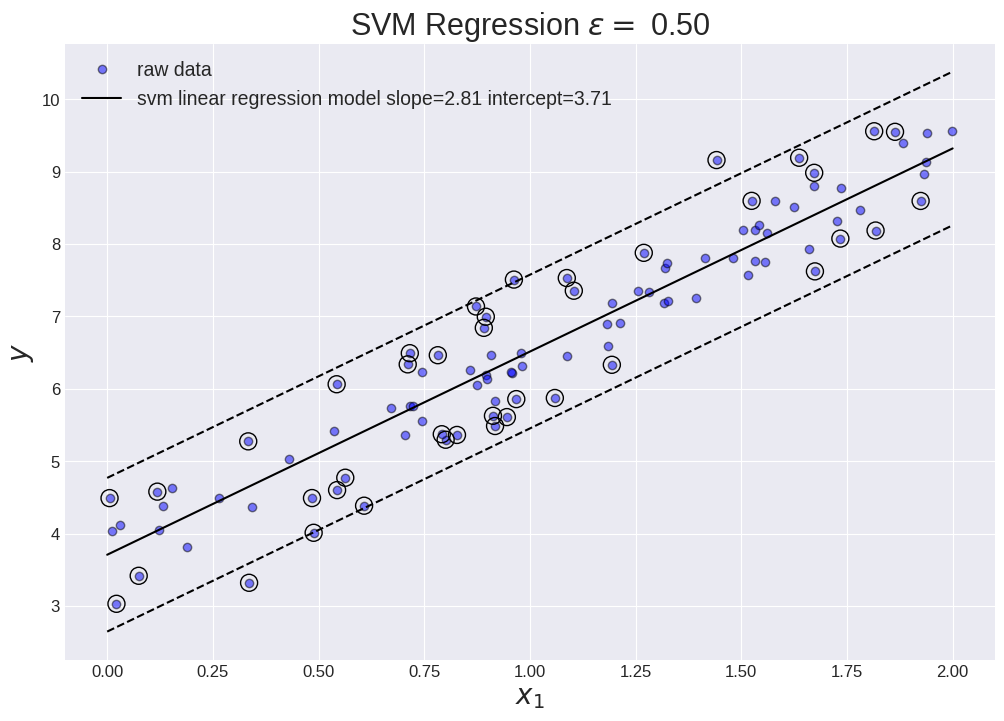

In [40]:
# visualize the linear regression fit
# TODO: the margins are not actually correct here yet, need to find a correct method to determine
# the fitted margin

# first plot the raw data
plt.plot(x, y, 'bo', alpha=0.5, markeredgecolor='k', label='raw data')

# Can get model regression line using basic predict function as usual
x_grid = np.linspace(0.0, 2.0, 2).reshape(2,1)
y_hat = svm_reg.predict(x_grid)
model_slope = svm_reg.coef_[0]
model_intercept = svm_reg.intercept_
label = 'svm linear regression model slope=%0.2f intercept=%0.2f' % (model_slope, model_intercept)
plt.plot(x_grid, y_hat, 'k-', label=label)

# identify the support vectors found by this SVR
sv_x = svm_reg.support_vectors_
sv_y_idx = svm_reg.support_
plt.scatter(sv_x, y[sv_y_idx],
            s=150,
            facecolors="none",
            zorder=10,
            edgecolors="k"
        )

# visualize the margin, using example from scikit-learn documentation:
# https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html
# plot the parallels to the separating hyperplane that pass through the
# support vectors (margin away from hyperplane in direction
# perpendicular to hyperplane). This is sqrt(1+a^2) away vertically in
# 2-d.
margin = 1 / np.sqrt(np.sum(svm_reg.coef_**2))
yy_down = y_hat - np.sqrt(1 + model_slope**2) * margin
yy_up = y_hat + np.sqrt(1 + model_slope**2) * margin
plt.plot(x_grid, yy_down, 'k--')
plt.plot(x_grid, yy_up, 'k--')


# add legend and labels
plt.title(r'SVM Regression $\epsilon = $ %0.2f' % epsilon, fontsize=22)
plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
plt.legend();

To tackle nonlinear regression tasks, you can use a kernelized SVM model. Figure 5-11
shows SVM Regression on a random quadratic training set, using a second-degree
polynomial kernel.

Again we will create a quadratic function similar to what looks to be given in figure 5-11 and fit a SVR
with a nonlinear polynomial kernel to the data.

In [41]:
# quadratic function estimated from figure 5-11
# y = theta_0 + theta_1 * x + theta_2 * x^2
theta = np.array([0.2, 0, 0.5])
x = np.random.uniform(-1, 1, (100,))
x = x.reshape((100,1))
p = PolynomialFeatures(degree=2)
X = p.fit_transform(x)
y = X @ theta
y = y + np.random.normal(0.0, 0.05, (100,))


In [42]:
epsilon = 0.1
C = 100
svm_reg = SVR(kernel='poly', degree=2, epsilon=epsilon, C=C)
svm_reg.fit(x, y)

SVR(C=100, degree=2, kernel='poly')

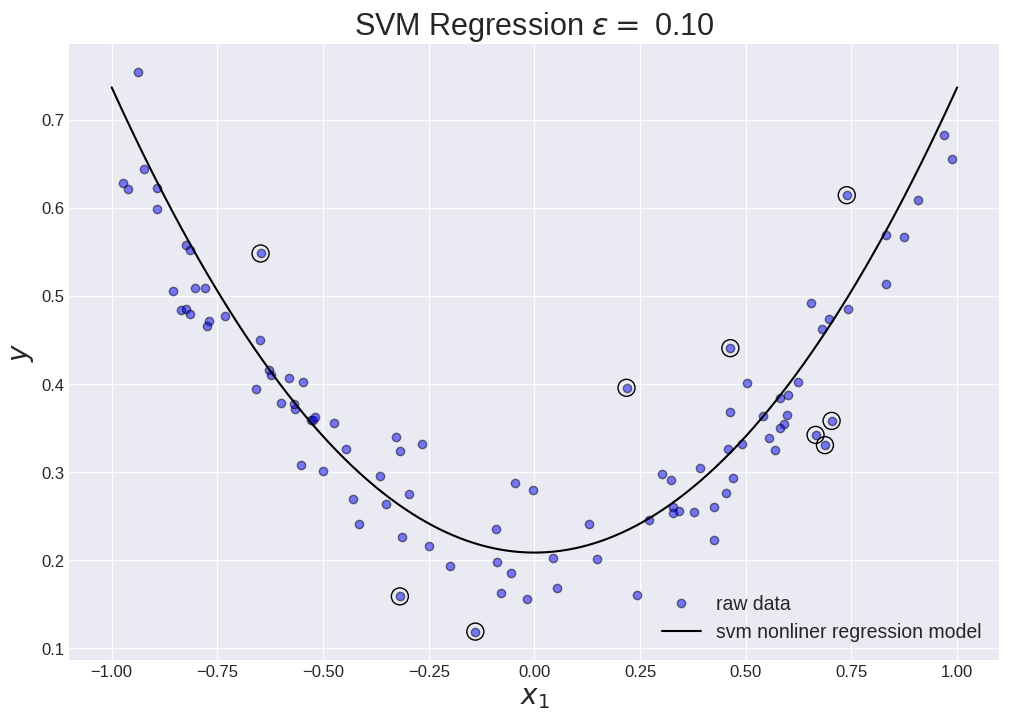

In [43]:
# visualize the linear regression fit
# TODO: the margins are not actually correct here yet, need to find a correct method to determine
# the fitted margin

# first plot the raw data
plt.plot(x, y, 'bo', alpha=0.5, markeredgecolor='k', label='raw data')

# Can get model regression line using basic predict function as usual
x_grid = np.linspace(-1.0, 1.0, 1000).reshape(1000,1)
y_hat = svm_reg.predict(x_grid)
label = 'svm nonliner regression model'
plt.plot(x_grid, y_hat, 'k-', label=label)

# identify the support vectors found by this SVR
sv_x = svm_reg.support_vectors_
sv_y_idx = svm_reg.support_
plt.scatter(sv_x, y[sv_y_idx],
            s=150,
            facecolors="none",
            zorder=10,
            edgecolors="k"
        )


# add legend and labels
plt.title(r'SVM Regression $\epsilon = $ %0.2f' % epsilon, fontsize=22)
plt.xlabel(r'$x_1$', fontsize=20)
plt.ylabel(r'$y$', fontsize=20)
plt.legend();